<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>
Author: Yury Kashnitsky, Data Scientist at Mail.Ru Group

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

## <center>Assignment #6. Solution
### <center> Beating benchmarks in "How good is your Medium article?"
    
[Competiton](https://www.kaggle.com/c/how-good-is-your-medium-article). The task is to beat "Assignment 6 baseline".

In [1]:
import os
import json
import pickle
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from datetime import datetime
from glob import glob
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import SGDRegressor
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import Ridge, RidgeCV, Lasso

The following code will help to throw away all HTML tags from an article content.

In [2]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

Supplementary function to read a JSON line without crashing on escape characters.

In [3]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

Parse JSON and extract some features.

In [4]:
def extract_features_and_write(path_to_data,
                               inp_filename, is_train=True):
    
    features = ['content', 'published', 'title', 'author']
    prefix = 'train' if is_train else 'test'
    feature_files = [open(os.path.join(path_to_data,
                                       '{}_{}.txt'.format(prefix, feat)),
                          'w', encoding='utf-8')
                     for feat in features]
    
    with open(os.path.join(path_to_data, inp_filename), 
              encoding='utf-8') as inp_json_file:

        for line in tqdm_notebook(inp_json_file):
            json_data = read_json_line(line)
            for i, feat in enumerate(features):
                if feat == 'published':
                    info = json_data[feat]['$date']
                elif feat == 'author':
                    info = json_data[feat]['twitter']
                    if info:
                        info = info.replace('\n', ' ').replace('@', ' ')
                    else:
                        info = ''
                elif feat == 'content' or feat == 'title':
                    info = json_data[feat].replace('\n', ' ').replace('\r', ' ')
                    info = strip_tags(info)                   
                feature_files[i].write(info + '\n')

In [5]:
extract_features_and_write('../data/', 'train.json', is_train=True)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [6]:
extract_features_and_write('../data/', 'test.json', is_train=False)

Widget Javascript not detected.  It may not be installed or enabled properly.


**Tf-Idf with article content.**

In [7]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   max_features=100000)

In [8]:
%%time
with open('../data/train_content.txt', encoding='utf-8') as input_train_file:
    X_train_content_sparse = tfidf_vectorizer.fit_transform(input_train_file)
    
with open('../data/test_content.txt', encoding='utf-8') as input_test_file:
    X_test_content_sparse = tfidf_vectorizer.transform(input_test_file)

CPU times: user 8min 9s, sys: 25 s, total: 8min 34s
Wall time: 8min 38s


In [9]:
X_train_content_sparse.shape, X_test_content_sparse.shape

((62313, 100000), (34645, 100000))

**Tf-Idf with titles.**

In [10]:
%%time
tfidf_vectorizer_title = TfidfVectorizer(ngram_range=(1, 3),
                                         max_features=100000)

with open('../data/train_title.txt', encoding='utf-8') as input_train_file:
    X_train_title_sparse = tfidf_vectorizer_title.fit_transform(input_train_file)
    
with open('../data/test_title.txt', encoding='utf-8') as input_test_file:
    X_test_title_sparse = tfidf_vectorizer_title.transform(input_test_file)

CPU times: user 6.09 s, sys: 147 ms, total: 6.23 s
Wall time: 6.27 s


In [11]:
X_train_title_sparse.shape, X_test_title_sparse.shape

((62313, 100000), (34645, 100000))

**Add time features.**

In [12]:
def add_time_features(path_to_publication_time_file):

    df = pd.read_csv(path_to_publication_time_file, names=['time'])
    df['time'] = df['time'].apply(lambda t: 
                              pd.to_datetime(t.replace('T', ' ').replace('Z', '')))
    df['hour'] = df['time'].apply(lambda ts: ts.hour)
    df['month'] = df['time'].apply(lambda ts: ts.month)
    
    df['weekend'] = df['time'].apply(lambda ts: ts.weekday() == 5 or
                                 ts.weekday() == 6).astype('int')
    
    df['day'] = ((df['hour'] >= 12) & (df['hour'] <= 18)).astype('int')
    df['morning'] = ((df['hour'] >= 7) & (df['hour'] <= 11)).astype('int')
    df['night'] = ((df['hour'] >= 0) & (df['hour'] <= 5)).astype('int')
    
    cols = ['day', 'morning', 'night', 'month', 'weekend']
    X_time_features_sparse = csr_matrix(df[cols].values)
    
    return X_time_features_sparse

In [13]:
%%time
X_train_time_features_sparse = add_time_features('../data/train_published.txt')
X_test_time_features_sparse = add_time_features('../data/test_published.txt')

CPU times: user 14.7 s, sys: 169 ms, total: 14.8 s
Wall time: 14.9 s


In [16]:
X_train_time_features_sparse.shape, X_test_time_features_sparse.shape

((62313, 5), (34645, 5))

**Add authors.**

In [22]:
%%time
author_train = pd.read_csv('../data/train_author.txt', names=['author'],
                          skip_blank_lines=False)
author_train = pd.get_dummies(author_train)

author_test = pd.read_csv('../data/test_author.txt', names=['author'],
                          skip_blank_lines=False)
author_test = pd.get_dummies(author_test)

unique_authors_train = list(set(author_train.columns) - set(author_test.columns))
unique_authors_test = list(set(author_test.columns) - set(author_train.columns))

author_test = author_test.drop(unique_authors_test, axis=1)
author_train = author_train.drop(unique_authors_train, axis=1)

X_train_author_sparse = csr_matrix(author_train.values)
X_test_author_sparse = csr_matrix(author_test.values)

CPU times: user 38.1 s, sys: 3.63 s, total: 41.7 s
Wall time: 42.2 s


In [23]:
X_train_author_sparse.shape, X_test_author_sparse.shape

((62313, 4587), (34645, 4587))

**Join all sparse matrices.**

In [24]:
X_train_sparse = csr_matrix(hstack([X_train_content_sparse, X_train_title_sparse,
                                    X_train_author_sparse, X_train_time_features_sparse]))

In [25]:
X_test_sparse = csr_matrix(hstack([X_test_content_sparse, X_test_title_sparse,
                                    X_test_author_sparse, X_test_time_features_sparse]))

In [26]:
X_train_sparse.shape, X_test_sparse.shape

((62313, 204592), (34645, 204592))

**Read train target and split data for validation.**

In [27]:
train_target = pd.read_csv('../data/train_log1p_recommends.csv', 
                           index_col='id')
y_train = train_target['log_recommends'].values

In [28]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_part_sparse = X_train_sparse[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid_sparse =  X_train_sparse[train_part_size:, :]
y_valid = y_train[train_part_size:]

**Train a simple Ridge model and check MAE on the validation set.**

In [30]:
%%time
ridge_reg = Ridge(random_state=17)
ridge_reg.fit(X_train_part_sparse, y_train_part)
ridge_valid_pred = ridge_reg.predict(X_valid_sparse)
print(mean_absolute_error(y_valid, ridge_valid_pred))

1.0978034600825612
CPU times: user 1min 43s, sys: 1.54 s, total: 1min 44s
Wall time: 1min 45s


Plot distributions of tagets and predictions for the validation set.

In [34]:
from matplotlib import pyplot as plt
%matplotlib inline

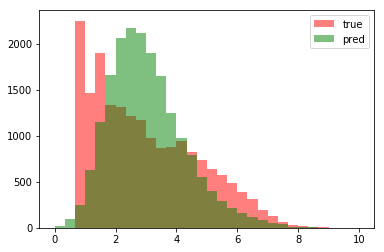

In [35]:
plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(ridge_valid_pred, bins=30, alpha=.5, color='green', label='pred', range=(0,10));
plt.legend();

**Train the same Ridge with all abailable data, make predictions for the test set and form a submission file.**

In [47]:
%%time
ridge_reg.fit(X_train_sparse, y_train)
ridge_test_pred = ridge_reg.predict(X_test_sparse)

CPU times: user 2min 46s, sys: 1.69 s, total: 2min 48s
Wall time: 2min 48s


In [32]:
def write_submission_file(prediction, filename,
                          path_to_sample='../data/sample_submission.csv'):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [33]:
write_submission_file(ridge_test_pred, 'assignment6_medium_submission.csv')

**With this you get ~ 1.73877 on public leaderboard.**

**Now's the time for dirty Kaggle hacks. Form a submission file with all zeroes. Make a submission. What do you get if you think about? How is it going to help you with modifying your predictions?**

In [50]:
write_submission_file(np.zeros_like(ridge_test_pred), 
                      'medium_all_zeros_submission.csv')

In [52]:
mean_test_target = 4.33328

**Calculate mean target for the test set.**

In [51]:
y_train.mean()

3.051538598205832

**Now we now that we need to add the difference between test and train mean targets.**

In [53]:
ridge_test_pred_modif = ridge_test_pred + mean_test_target - y_train.mean()

In [54]:
write_submission_file(ridge_test_pred_modif, 
                      'assignment6_medium_submission_with_hack.csv')

**That's it!**